# Esercizio 2.1: Text segmentation

Per la realizzazione di questo esercizio si è usata l'implementazione descritta da *Goran Glavas, 
Federico Nanni, Simone Paolo Ponzetto* dell'algoritmo di `GRAPHSEG` tratto dall'articolo:
```
Glavaš, Goran & Nanni, Federico & Ponzetto, Simone. (2016). Unsupervised Text Segmentation Using Semantic Relatedness Graphs. 125-130. 10.18653/v1/S16-2016. 
```

L'idea consiste nel creare un grafo dove ogni nodo rappresenta una frase del testo di partenza e tali nodi son collegati soltanto se tra le frasi esiste un livello di similarità superiore ad una soglia impostata in base ai test.

Inizialmente costruiremo il grafo estraendo le frasi dal testo, seguirà una sezione dettagliata sul calcolo matematico per la similarità delle frasi e in fine costruiremo i nostri insiemi di sentenze sulla base di questi legami del grafo.

In [74]:
## Costruiamo il nostro grafo
import nltk
from igraph import Graph


input_document = ''

with open('input_ex_2_1.txt', 'r') as file:
    input_document = file.read()

g = Graph()
sentence_dict = {}
for idx, sent in enumerate(nltk.sent_tokenize(input_document)):
    sentence_dict[idx] = sent
    g.add_vertices(1)

print(g)

IGRAPH U--- 18 0 --


## Correlazione semantica delle frasi

Implementiamo il calcolo di similarità usato per confrontare due frasi:

Definiamo come A un set di coppie di parole dove la prima parola appartiene alla prima frase e la seconda alla seconda frase:

<center>$A = {(w1, w2) | w1 ∈ S1 ∧ w2 ∈ S2}$</center>

Definiamo quindi la similarità tra due frasi come:
<div>
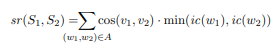
</div>

Dove v1 e v2 sono i *embedding vector* e ic è *information content*

<div>
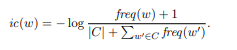
</div>
<!--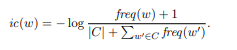-->

Infine per normalizzare il risultato si userà la seguente formula:
<div>
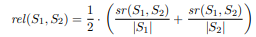
</div>
    
   
Nel dettaglio, iniziamo con il caricare i corpus che ci serviranno per le varie fasi:

In [2]:
import spacy
from nltk.corpus import gutenberg
from collections import Counter
from math import log
from nltk.corpus import stopwords

# Carichiamo le stop words
stop_words = set(stopwords.words('english'))

# Carichiamo il corpus per il calcolo del valore di Information Content
def load_ics_dict():
    new_dict = Counter()
    for fileid in gutenberg.fileids():
        new_dict += Counter([w for w in gutenberg.words(fileid) if w.isalpha()])
    return dict(new_dict)

# Per agevolare i calcoli, i valori fissi son salvati come variabili globali
gutenberg_corpus_list = load_ics_dict()
gut_dim = len(gutenberg_corpus_list)
gut_total_freq = sum(gutenberg_corpus_list.values())

# Carichiamo il modello per il calcolo del Vector Space con Spacy
nlp = spacy.load('en_core_web_lg')


Di seguito definiamo i metodi necessari per il calcolo della formula generale:
<div>
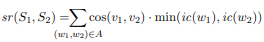
</div>

L'idea alla base è di pesare la similarità di due parole in base al tipo di conenuto che esse portano. Come per il *TF IDF* visto a lezione, il valore di *IC* è tanto maggiore quanto più una parola è poco presente nelle varie frasi, garantendo quindi di non essere un termine di uso comune ma una parola di contenuto significativo.

Per la *cosine similarity* usiamo il modello della risorsa `Spacy` che tramite la semplice chiamata `nlp(word)` restituisce il suo vettore e applichiamo la funzione di similarità che per default è la *cosine*.

Per il calcolo della *information content (IC)* abbiamo importato il corpus `gutenberg` che contiene 25 libri presente nella risorsa di *nltk*. Dal momento che la parte al denominatore è un calcolo fisso è già stata calcolata nello step precedente e memorizzata come variabile globale. La formula di partenza è la seguente:

<div>
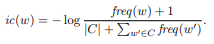
</div>

In [86]:
def get_cosine_similarity(word1, word2):
    return nlp(word1).similarity(nlp(word2))

def ic(word):
    freq = gutenberg_corpus_list.get(word) if word in gutenberg_corpus_list.keys() else 0
    return -log((freq + 1)/ (gut_dim + gut_total_freq))

def min_information_content(word1,word2):
    return min(ic(word1), ic(word2))

# Example
print(get_cosine_similarity('dog','cat'))
print(ic('guitar'))
print(ic('the'))

0.8016854705531046
13.498828007379032
2.8553971604030584


In fine definiamo i metodi per il calcolo della correlazione semantica generali.

Filtriamo le parole delle stop_words, anche se l'utilizzo della formula *IC* non dovrebbe richiedere questa 
necessità e eliminiamo i termini che non son parole in quanto il corpus contiene molto rumore.

Per concludere applichiamo la normalizzazione accennata in precedenza dalla formula:
<div>
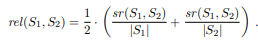
</div>

In [81]:
from nltk.tokenize import word_tokenize
import nltk
from itertools import product

def semantic_relatedness(sentence1, sentence2):
    sr = 0
    # preprocessing
    sent1 = [w for w in word_tokenize(sentence1) if not w.lower() in stop_words and w.isalpha()]
    sent2 = [w for w in word_tokenize(sentence2) if not w.lower() in stop_words and w.isalpha()]
    # calcolo
    for w1,w2 in product(sent1,sent2):
        sr += get_cosine_similarity(w1, w2) * min_information_content(w1, w2)
    return sr, len(sent1), len(sent2)

def normalized_sr(sentence1, sentence2):
    if sentence1 is None or sentence2 is None:
        return 0
    sr, len1, len2 = semantic_relatedness(sentence1, sentence2)
    return 0.5 * (sr/len1 + sr/len2)

# Example
print(normalized_sr(sentence_dict[14], sentence_dict[13]))
# Nota: Viene stampato un warning inerente all'uso di Spacy, il warning capita quando si incontrano parole che non trovano
#       confronto nel modello e quindi assumono un vettore vuoto, non è un problema perchè la similarità in tal caso sarà 0

33.35621348828165


## Aggiungiamo gli edge al nostro grafo

Terminata la costruzione della nostra similarità possiamo continuare con l'algoritmo di `GRAPHSEG` che prevede di aggiungere un arco per ogni nodo la cui similarità è superiore ad una certa soglia scelta manualmente:


In [87]:
from itertools import combinations

# Per ogni coppia di frasi nel documento, quindi nelle key della nostra dictionary
for s1, s2 in combinations(sentence_dict.keys(), 2):
    if normalized_sr(sentence_dict.get(s1), sentence_dict.get(s2)) > 50:
        g.add_edges([(s1,s2)])
        print('added new edge', (s1,s2))
        
print(g)


<ipython-input-86-0b136caf1d41>:2: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return nlp(word1).similarity(nlp(word2))


added new edge (0, 4)
added new edge (0, 15)
added new edge (0, 17)
added new edge (1, 4)
added new edge (3, 4)
added new edge (3, 5)
added new edge (3, 15)
added new edge (3, 17)
added new edge (4, 5)
added new edge (4, 15)
added new edge (4, 16)
added new edge (4, 17)
added new edge (5, 15)
added new edge (5, 17)
added new edge (15, 16)
added new edge (15, 17)
added new edge (16, 17)
IGRAPH U--- 18 17 --
+ edges:
0--4 0--15 0--17 1--4 3--4 3--5 3--15 3--17 4--5 4--15 4--16 4--17 5--15 5--17
15--16 15--17 16--17


## Cerchiamo i *cliques* del grafo

Costruito il nostro grafo compreso di archi possiamo procedere all'individuazione dei sottoinsiemi che useremo per 
spezzetare il documento

Si inizia partendo dai cliques calcolati mediante una versione modificata dell'algoritmo di `Bron-Kerbosch` presente nella 
libreria igraph

In [88]:
from igraph import GraphBase
# Initial Cliques
Q = GraphBase.maximal_cliques(g, 1, 0)
print(Q)

[(10,), (11,), (2,), (14,), (13,), (12,), (6,), (7,), (8,), (9,), (1, 4), (0, 4, 17, 15), (16, 4, 17, 15), (4, 3, 17, 15, 5)]


## Primo ciclo: Creiamo i segmenti iniziali

Dal risultato dell'algoritmo di `Bron-Kerbosch` otteniamo una serie di insiemi su cui andremo ad apportare modifiche nei
prossimi pezzi di codice.

La prima modifica è la seguente: 
    Creiamo il set di segmenti iniziale `SG` unendo le frasi adiacenti che compaiono almeno in un *maximal cliques* di Q
    
Per implementarlo costruiamo un metodo di appoggio `sg` che restituisce il *clique* corrispondente da *SG* data una frase.

Esempio:
``` Cliques Q {1, 2, 6}, {2, 4, 7}, {3, 4, 5}, {1, 8, 9}
Init. seg. {1, 2}, {3, 4, 5}, {6}, {7} {8, 9}```

In [89]:
SG = []
# Esempio articolo, decommentare per provare l'esempio dell'articolo
# Q = [(1, 2, 6), (2, 4, 7), (3, 4, 5), (1, 8, 9)]
# risultato atteso -> {1, 2}, {3, 4, 5}, {6}, {7} {8, 9}


def sg(s):
    r = [item for item in SG if s in item]
    return r[0] if r else None

#  creating initial segments from cliques
for clique in Q:
    for s1, s2 in combinations(clique, 2):
        if abs(s2-s1) == 1:
            if sg(s1) is None and sg(s2) is None:
                SG.append([s1,s2])
            elif sg(s1) is not None and sg(s2) is None:
                sg(s1).append(s2)
            elif sg(s1) is None and sg(s2) is not None:
                sg(s2).append(s1)
#  add segment without connection
for clique in Q:
    for s in clique:
        if sg(s) is None:
            SG.append([s])

SG.sort()
print(SG)

[[0], [1], [2], [4, 3, 5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [16, 17, 15]]


## Secondo ciclo: Uniamo i segmenti adiacenti

In questo loop uniamo i segmenti adiacenti `sg_i` e `sg_next`(i+1) per cui esista almeno un *cliques* in Q che contiene almeno
una frase da *sg_i* e almeno una da *sg_next*

Esempio:
```Cliques Q {1, 2, 6}, {2, 4, 7}, {3, 4, 5}, {1, 8, 9}
Init. seg. {1, 2}, {3, 4, 5}, {6}, {7} {8, 9}
Merge seg. {1, 2, 3, 4, 5}, {6}, {7}, {8, 9}```

In [90]:
# merging adjacent segments
for i, sg_i in enumerate(SG):
    if i == len(SG)-1:
        continue
    sg_next = SG[i+1]
    found = False
    for clique in Q:
        for s1, s2 in combinations(clique, 2):
            if s1 in sg_i and s2 in sg_next:
                found = True
    if found:
        SG.remove(sg_i)
        SG.remove(sg_next)
        SG.append(sg_i + sg_next)
        SG.sort()
SG.sort()
print(SG)

[[0], [1], [2], [4, 3, 5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [16, 17, 15]]


## Ultimo ciclo: uniamo i segmenti troppo piccoli

L'ultima fase consiste nell'unire i segmenti che son ritenuti troppo piccoli. Per fare ciò è stata introdotta una variabile
`n` impostata a 2 che setta la soglia minima di due frasi per poter considerare un set finale.

Per decidere come unire i set che contengono meno di due frasi si costruisce il metodo `sgr` che esegue la media di 
Correlazione semantica coi set vicini e unisce quello singolo con quello più simile.

Come da formula:
<div>
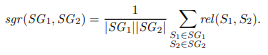
</div>


In [91]:

n = 2

def sgr(sg1, sg2):
    if sg1 is None or sg2 is None:
        return 0
    sum = 0
    for s1,s2 in product(sg1,sg2):
        sum += normalized_sr(sentence_dict.get(s1), sentence_dict.get(s2))
    return sum / (len(sg1)*len(sg2))

# merging too small segments
stop = False
while not stop: 
    sg_i = next((x for x in SG if len(x) < n), None)
    if sg_i is None:
        stop = True
        break
    i = SG.index(sg_i)
    sg_prev = SG[i-1] if i>0 else None
    sg_next = SG[i+1] if i<len(SG)-1 else None
    if sgr(sg_prev, sg_i) >= sgr(sg_i, sg_next):
        SG.remove(sg_prev)
        SG.remove(sg_i)
        SG.append(sg_prev + sg_i)
    else:
        SG.remove(sg_i)
        SG.remove(sg_next)
        SG.append(sg_i + sg_next)      
    SG.sort()

SG.sort()
print(SG)

[0]
0
[2]
1


<ipython-input-86-0b136caf1d41>:2: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return nlp(word1).similarity(nlp(word2))


[6]
2
[8]
3
[9]
3
[10]
3
[11]
3
[13]
4
[[0, 1], [2, 4, 3, 5], [6, 7, 8, 9, 10], [11, 12], [13, 14], [16, 17, 15]]


## Risultato
Per concludere ricostruiamo i paragrafi suddivisi ottenuti come risultato:

In [92]:
for sg in SG:
    sg.sort()
    print("NEW SECTION:")
    print(' '.join([sentence_dict.get(text) for text in sg]))
    print("\n\n\n")

NEW SECTION:
World War II is generally considered to have begun on 1 September 1939, when Nazi Germany, under Adolf Hitler, invaded Poland. The United Kingdom and France subsequently declared war on Germany on the 3rd.




NEW SECTION:
Under the Molotovâ€“Ribbentrop Pact of August 1939, Germany and the Soviet Union had partitioned Poland and marked out their "spheres of influence" across Finland, Romania and the Baltic states. From late 1939 to early 1941, in a series of campaigns and treaties, Germany conquered or controlled much of continental Europe, and formed the Axis alliance with Italy and Japan (along with other countries later on). Following the onset of campaigns in North Africa and East Africa, and the fall of France in mid-1940, the war continued primarily between the European Axis powers and the British Empire, with war in the Balkans, the aerial Battle of Britain, the Blitz of the UK, and the Battle of the Atlantic. On 22 June 1941, Germany led the European Axis powers in